Code for generating train/val/test splits in body condition data

In [2]:
import pandas as pd
import json
from pycocotools.coco import COCO
import random
import matplotlib.pyplot as plt
import os

Import Data

In [20]:
# import annotations
root = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/notebooks/data_splitting/'

annotations_path = os.path.join(root, 'merged_coco.json')
coco = COCO(annotations_path)

annotation_ids = coco.getAnnIds() 
annotations = coco.loadAnns(annotation_ids) 
segmented_annotations = [ann for ann in annotations if ann.get('segmentation')] # annotations with valid masks
segmented_image_ids = {ann['image_id'] for ann in segmented_annotations} # ids associted with valid masks


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [21]:
# import metadata
metadata_path = os.path.join(root, 'metadata.csv')
metadata_df = pd.read_csv(metadata_path)

# filter to only annotated data
filtered_df = metadata_df[metadata_df['filename'].isin(
    [coco.loadImgs(image_id)[0]['file_name'] for image_id in segmented_image_ids])] # filter df to only mask annotated images

# group together individual-flight-date information
filtered_df['Individual-Flight-Date'] = filtered_df['White.Shark.ID'] + '-' + filtered_df['filename'].str.slice(12, 14) + '-' + filtered_df['date'] 


/tmp/ipykernel_206836/2796123141.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Individual-Flight-Date'] = filtered_df['White.Shark.ID'] + '-' + filtered_df['filename'].str.slice(12, 14) + '-' + filtered_df['date']


Assign splits

In [22]:
n_groups = len(filtered_df['Individual-Flight-Date'].unique()) # gives total possible groups 

# set train and validation proportions
train_prop = 0.85
val_prop = 0.15

# set seed
random.seed(1997) 

# get n for train and val sets
n_train = round(train_prop*n_groups)
n_val = round(val_prop*n_groups)

group_values = filtered_df['Individual-Flight-Date'].unique() # variable that we want to group by
random.shuffle(group_values) # randomly shuffle that list 

train_values = group_values[:n_train] # assign train values
val_values = group_values[n_train:] # assign validation values

# Create a copy of the original DataFrame to avoid modifying it directly
df_split = filtered_df.copy()

# add a 'split' col to the original df to indicate set assignment
df_split['split'] = df_split['Individual-Flight-Date'].apply(
    lambda x: 'train' if x in train_values else 'validation'
)

Separate Filenames into Train and Val

In [24]:
# extract lists of train and validation filenames as .txt files
train_df = df_split[df_split['split'] == 'train']
train_filenames = train_df['filename'].tolist()
df_train_filenames = pd.DataFrame(train_filenames, columns=['filename'])

val_df = df_split[df_split['split'] == 'validation']
val_filenames = val_df['filename'].tolist()
df_val_filenames = pd.DataFrame(val_filenames, columns=['filename'])

In [34]:
# grab subsection of filenames (optional, for creating split_debug only)
train_filenames = train_filenames[:2]
val_filenames = val_filenames[:2]

Separate Annotations into Train and Val

In [35]:
# grab train and val image ids
train_image_ids = {img['id'] for img in coco.loadImgs(coco.getImgIds()) if img['file_name'] in train_filenames}
val_image_ids = {img['id'] for img in coco.loadImgs(coco.getImgIds()) if img['file_name'] in val_filenames}

# grab train and val anns (incorrect #)
train_annotations = [ann for ann in annotations if ann['image_id'] in train_image_ids]
val_annotations = [ann for ann in annotations if ann['image_id'] in val_image_ids]

# grab images
train_images = [img for img in coco.dataset['images'] if img['id'] in train_image_ids]
val_images = [img for img in coco.dataset['images'] if img['id'] in val_image_ids]

# create train coco dataset
train_dataset = {
    'info': coco.dataset['info'],
    'licenses': coco.dataset['licenses'],
    'images': train_images,
    'annotations': train_annotations,
    'categories': coco.dataset['categories']
}

# create val coco dataset
val_dataset = {
    'info': coco.dataset['info'],
    'licenses': coco.dataset['licenses'],
    'images': val_images,
    'annotations': val_annotations,
    'categories': coco.dataset['categories']
}

In [38]:
#len(annotations) #annotations is correctly of len 1061
len(val_images) # val is correctly of size 172 (or 2 for debug)


2

Export data splits

In [40]:
train_val_root = '/mnt/class_data/group2/alexandradigiacomo/dataset/annotations/'
split_folder = 'split_debug/' # change annotation folder here based on split

# write entire metadata df out
filtered_df.to_csv(os.path.join(root, split_folder, 'splitAssignment.csv')) 

# write individual lists of filenames out
df_train_filenames.to_csv(os.path.join(root, split_folder, 'train_filenames.csv'))
df_val_filenames.to_csv(os.path.join(root, split_folder, 'val_filenames.csv'))

# write annotations out
with open(os.path.join(train_val_root, split_folder, 'train.json'), 'w') as train_file:
    json.dump(train_dataset, train_file)

with open(os.path.join(train_val_root, split_folder, 'val.json'), 'w') as val_file:
    json.dump(val_dataset, val_file)

Visualize Splits

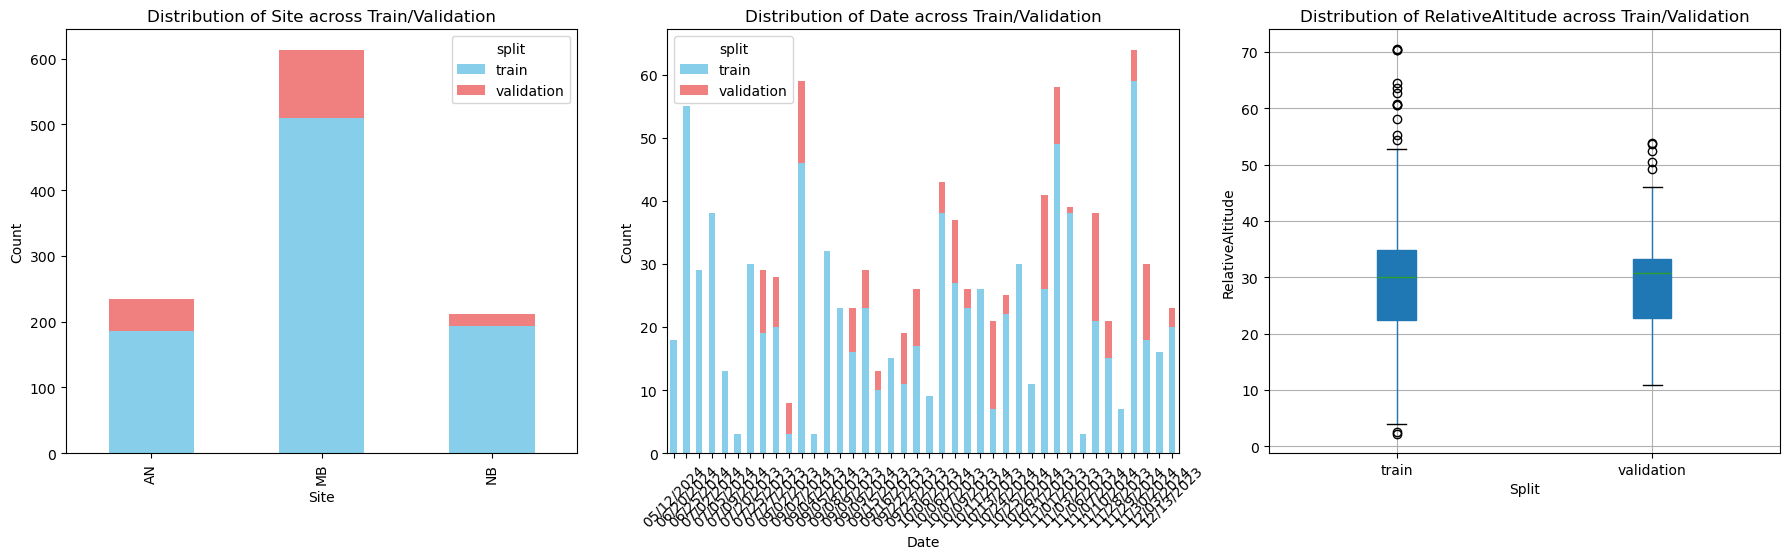

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Site Distribution
site_counts = df_split.groupby(['site', 'split']).size().unstack().fillna(0)
site_counts.plot(kind='bar', stacked=True, ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Distribution of Site across Train/Validation')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Site')

# Date distribution
date_counts = df_split.groupby(['date', 'split']).size().unstack().fillna(0)
date_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_title('Distribution of Date across Train/Validation')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
axes[1].tick_params(axis='x', rotation=45)

# Altitude distribution
df_split.boxplot(column='RelativeAltitude', by='split', ax=axes[2], patch_artist=True)
axes[2].set_title('Distribution of RelativeAltitude across Train/Validation')
axes[2].set_ylabel('RelativeAltitude')
axes[2].set_xlabel('Split')

plt.tight_layout()
plt.suptitle('')  # Remove the default title from `plt.suptitle()`
plt.show()